In [1]:
import math
import torch
import gpytorch

import pyro
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [2]:
%pdb

Automatic pdb calling has been turned ON


## Introduction

In this notebook, we how to train a functional kernel learning model, training on a simple function. We'll be modeling the function

\begin{align*}
  y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2)
\end{align*}

with 11 training examples, and testing on 51 test examples.

For more mathematical detail, please see the paper Functional Distributions over Kernels (NeurIPS 2019).

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf


#### Set up the GPyTorch Model with Spectral GP kernel
Using the same framework as standard GPyTorch models, we merely drop-in the spectral GP kernel as the covar module

The `initialize_from_data` method does some pre-training on the latent model using the log-periodogram of data as training targets.

For specifics on the components of GPyTorch models we refer to the [GPyTorch Documentation](https://gpytorch.readthedocs.io/en/latest/index.html)

In [3]:
class SpectralModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, **kwargs):
        super(SpectralModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralGPKernel(**kwargs)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


#### Generate training data and Build GP Model
Generate points in [0, 5] and a sine wave to serve as the response, then split into training and test data.

Pass this data into the GP model from above along with a likelihood

In [4]:
nx = 200
split = 150
full_x = torch.linspace(-15., 15., nx).cuda()

sinc = lambda x: torch.sin(math.pi * x) / (math.pi * x)
sinc_testfn = lambda x: sinc(x) + sinc(x - 10.) + sinc(x + 10.)

full_y = sinc_testfn(full_x)

train_set = ~((full_x > -4.5) * (full_x < 4.5))
train_x = full_x[train_set]
train_y = full_y[train_set]

test_x = full_x[~train_set]
test_y = full_y[~train_set]

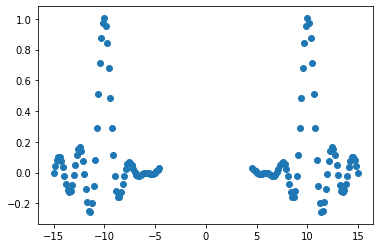

In [5]:
plt.scatter(train_x.cpu().numpy(), train_y.cpu().numpy())

### Define latent model

In [6]:
class FKL_GPModel(gpytorch.likelihoods.GaussianLikelihood):
    def __init__(self, train_x, train_y, data_likelihood, **kwargs):
        super(FKL_GPModel, self).__init__()
        
        self._max_plate_nesting = 1
        self.data_likelihood = data_likelihood
        self.data_model = SpectralModel(train_x, train_y, self.data_likelihood, 
                                        **kwargs)
        self.train_x = train_x
        self.train_y = train_y
           
    @staticmethod
    def gplink_function(f):
        ### gp link function is inside the kernel
        return f.view(-1)
    
    def forward(self, function_samples, *params, **kwargs):
        latent_gp = self.gplink_function(function_samples)

        self.data_model.covar_module.set_latent_params(latent_gp)
        
        self.data_model.train()
        
        if not self.training:
            print('in eval mode')
            self.data_model.eval()
            dist = self.data_model(*params, **kwargs)
        else:
            dist = self.data_likelihood(self.data_model(self.train_x))
        
            #with torch.no_grad():
            #    print('forwards into dist: ', dist.log_prob(self.train_y))
        return dist

In [7]:
#omega = torch.arange(1e-4, 1., 0.01)

data_lh = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.SmoothedBoxPrior(1e-8, 1e-4)).cuda()
data_gp = FKL_GPModel(train_x, train_y, data_lh, train_inputs = train_x, register_latent_params=False,
                     period_factor=16.).cuda()
data_gp.train()
data_lh.train()


GaussianLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
  (noise_covar): HomoskedasticNoise(
    (noise_prior): SmoothedBoxPrior()
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [8]:
omega = data_gp.data_model.covar_module.omega.data.cuda()


In [9]:
from gpytorch.means import QuadraticMean
from gpytorch.priors import NormalPrior
from gpytorch.constraints import LessThan, GreaterThan
from gpytorch.kernels import ScaleKernel, MaternKernel, GridKernel
from gpytorch.models import PyroVariationalGP
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy

# we construct a Scale(Matern 3/2) kernel with a quadratic mean by default
class PyroGPModel(PyroVariationalGP):
    def __init__(self, train_x, train_y, likelihood, mean_module, covar_module):
        # Define all the variational stuff
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=int(train_x.numel())
        )
        variational_strategy = VariationalStrategy(
            self, train_x, variational_distribution
        )

        super(PyroGPModel, self).__init__(variational_strategy, likelihood, num_data=train_x.numel())
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return MultivariateNormal(mean, covar)

# construct by default a LogRBF prior on the latent spectral GP
# latent_mean = QuadraticMean(quadratic_weights_constraint=LessThan(upper_bound=0.0),
#                            bias_constraint=GreaterThan(lower_bound=0.0), 
#                            use_weights=False)#.to(device)
# latent_mean.quadratic_weights.data.fill_(-16.)
# latent_mean.bias.data.fill_(5.)
latent_mean = QuadraticMean(input_size = 1, raw_quadratic_weights_constraint=gpytorch.constraints.LessThan(0.0),
                         raw_bias_constraint=gpytorch.constraints.Positive(), use_weights=False)
latent_mean.quadratic_weights = -10.
latent_mean.bias = 5.

latent_covar = ScaleKernel(
    MaternKernel(nu=1.5, lengthscale_prior=NormalPrior(torch.zeros(1), torch.ones(1), transform=torch.exp)),
    outputscale_prior=NormalPrior(torch.zeros(1), torch.ones(1), transform=torch.exp),
)

latent_model = PyroGPModel(
    omega, None, data_gp, mean_module=latent_mean, covar_module=latent_covar
).cuda()

In [10]:
data_gp.train();
latent_model.train();

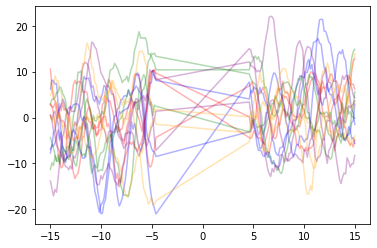

In [11]:
cols = ['red', 'blue', 'green', 'purple', 'orange']
for sample_num in range(5):
    latent_sample = latent_model(omega).rsample()
    
    prior_dist = data_gp(latent_sample, train_x)
    prior_preds = prior_dist.sample(torch.Size((3,)))
    
    plt.plot(train_x.cpu(), prior_preds.data.t().cpu().numpy(), color = cols[sample_num], alpha = 0.3)

In [12]:
# train the model
from pyro import optim

base_lr = 5e-3
iter_print = 250

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": 0.01}
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": base_lr}
    else:
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf, means = [], [], []

means.append(latent_model.variational_strategy.variational_distribution.\
             variational_mean.detach().cpu().numpy()) #save initial mean

num_iter = 5000
#def train(num_iter=5000):
elbo = pyro.infer.Trace_ELBO(num_particles=1, vectorize_particles=True)
svi = pyro.infer.SVI(latent_model.model, latent_model.guide, optimizer, elbo)
latent_model.train()

for i in range(num_iter):
    latent_model.zero_grad()
    loss = svi.step(omega, train_y)
    #print(latent_model(omega).log_prob(data_gp.data_model.covar_module.latent_params).sum(), 
    #     data_gp.data_model.covar_module.latent_params.norm())
    losses.append(loss)
    rbf.append(latent_model.covar_module.base_kernel.lengthscale.item())
    if not (i + 1) % iter_print:
        print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}'.format(
            i + 1, num_iter, loss,
            latent_model.covar_module.base_kernel.lengthscale.item(),
        ))
        means.append(latent_model.variational_strategy.variational_distribution.\
                     variational_mean.detach().cpu().numpy())
        #model_trace, guide_trace = list(elbo._get_traces(latent_model.model, latent_model.guide, omega, train_y))[0]
        print(latent_model.mean_module.bias)
        prior_dist = latent_model.variational_strategy.prior_distribution
        inducing_values_samples = latent_model.sample_inducing_values(prior_dist)
        data_dist = data_gp(inducing_values_samples)
        print('data ll: ', data_dist.log_prob(train_y))
        print('data_dist max eval: ', torch.symeig(data_dist.covariance_matrix)[0].max())
        #print('var dist log det:', latent_model.variational_strategy.variational_distribution.chol_variational_covar.diag().log().sum())
        #print('elbo traces are: ', model_trace.log_prob_sum(), guide_trace.log_prob_sum())
        
#%time train()

Basic lr for most of parameters: 0.005
Iter 250/5000 - Loss: 6e+03   lengthscale: 0.109
tensor([4.8859], device='cuda:0', grad_fn=<SoftplusBackward>)
data ll:  tensor(-121.9077, device='cuda:0', grad_fn=<MulBackward0>)
data_dist max eval:  tensor(1213.0747, device='cuda:0', grad_fn=<MaxBackward1>)
Iter 500/5000 - Loss: 2.22e+03   lengthscale: 0.0854
tensor([4.2964], device='cuda:0', grad_fn=<SoftplusBackward>)
data ll:  tensor(-43.3406, device='cuda:0', grad_fn=<MulBackward0>)
data_dist max eval:  tensor(635.9915, device='cuda:0', grad_fn=<MaxBackward1>)
Iter 750/5000 - Loss: -1.82e+03   lengthscale: 0.0674
tensor([3.7866], device='cuda:0', grad_fn=<SoftplusBackward>)
data ll:  tensor(32.1776, device='cuda:0', grad_fn=<MulBackward0>)
data_dist max eval:  tensor(378.3776, device='cuda:0', grad_fn=<MaxBackward1>)
Iter 1000/5000 - Loss: -5.68e+03   lengthscale: 0.0526
tensor([3.1558], device='cuda:0', grad_fn=<SoftplusBackward>)
data ll:  tensor(113.8771, device='cuda:0', grad_fn=<MulBack

In [13]:
latent_model.variational_strategy.variational_distribution.chol_variational_covar.diag().log().sum()

tensor(-31.8269, device='cuda:0', grad_fn=<SumBackward0>)

Text(0, 0.5, 'Kernel scale parameter')

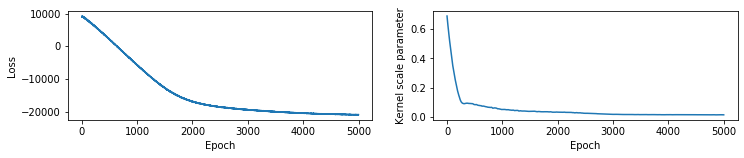

In [14]:
# prot loss function and kernel length
fig, (loss, kern) = plt.subplots(1,2,figsize=(12,2))
loss.plot(losses)
loss.set_xlabel("Epoch")
loss.set_ylabel("Loss")
kern.plot(rbf)
kern.set_xlabel("Epoch")
kern.set_ylabel("Kernel scale parameter")


In [28]:
data_gp.eval()

latent_model.train()

with torch.no_grad():
    output_dist = latent_model(omega)
    
samples = output_dist.sample(torch.Size((20,)))

In [29]:
output_dist.mean

Parameter containing:
tensor([ -8.1916,  -8.9429,  -8.7853,  -8.2884,  -7.8617,  -7.8240,  -7.2085,
         -4.5077,  -1.2234,  -6.0052,  -5.5730,  -0.3247,  -1.6602,  -4.4987,
         -5.8813,  -5.6193,  -6.6322,  -7.7465,  -7.3005,  -0.2613,  -7.4815,
         -8.5068,  -7.6260,  -0.1889,  -7.5505,  -8.1716,  -7.2204,  -6.0862,
         -6.3568,  -5.0646,  -1.3211,  -0.1966,  -6.2956,  -7.5439,  -7.3573,
         -6.9198,  -6.5719,  -1.9072,  -2.0241,  -7.5502,  -9.0850,  -9.8613,
         -9.9662, -10.0410, -10.7902, -11.1091, -11.0941, -11.2897, -11.5161,
        -11.4460], device='cuda:0', requires_grad=True)

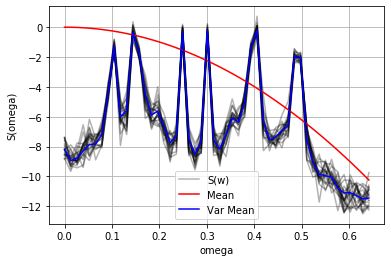

In [37]:
for i, sample in enumerate(samples):
    if i is 0:
        plt.plot(omega.cpu(), sample.cpu(), color = 'black', alpha = 0.3, label = 'S(w)')
    else:
        plt.plot(omega.cpu(), sample.cpu(), color = 'black', alpha = 0.3)
plt.plot(omega.cpu(), latent_model.mean_module(omega).data.cpu(), color = 'red', label = 'Mean')
plt.plot(omega.cpu(), output_dist.mean.data.cpu(), color='blue', label = 'Var Mean')

plt.xlabel('omega')
plt.ylabel('S(omega)')
plt.grid()
plt.legend()

in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode
in eval mode


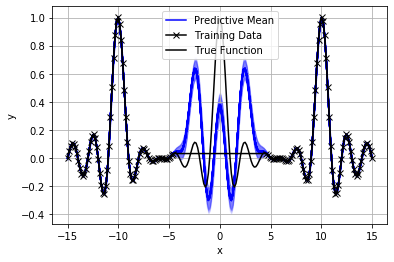

In [31]:
data_gp.eval()

for i, sample in enumerate(samples):
    with gpytorch.settings.fast_pred_var():
        pred_dist = data_gp(sample.data, full_x.cuda())
    
    pred_mean = pred_dist.mean.data.cpu().numpy()
    lower, upper = pred_dist.confidence_region()
    
    if i is 0:
        plt.plot(full_x.cpu(), pred_mean, color = 'blue', label = 'Predictive Mean')
    else:
        plt.plot(full_x.cpu(), pred_mean, color = 'blue')
    
    plt.fill_between(full_x.cpu().numpy(), lower.data.cpu().numpy(), upper.data.cpu().numpy(), alpha = 0.03, color = 'blue')
    
plt.plot(train_x.cpu(), train_y.cpu(), marker = 'x', color = 'black', label = 'Training Data')
plt.plot(full_x.cpu(), full_y.cpu(), color = 'black', label = 'True Function')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [32]:
covar_output = data_gp.data_model.covar_module(torch.zeros(1).cuda(), torch.linspace(0., 80., 200).cuda()).evaluate()

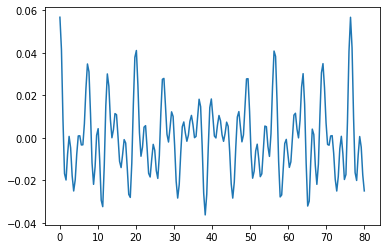

In [33]:
plt.plot(torch.linspace(0., 80., 200), covar_output.view(-1).cpu().numpy())